In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import easyocr

In [19]:
IMAGE_PATH = 'multipara2.jpeg'

In [20]:
def create_para(resultp, x_ths=1, y_ths=0.3, mode='ltr'):
    box_grp = []
    for box in resultp:
        x_coor = [int(coord[0]) for coord in box[0]]
        y_coor = [int(coord[1]) for coord in box[0]]
        min_x = min(x_coor)
        max_x = max(x_coor)
        min_y = min(y_coor)
        max_y = max(y_coor)
        height = max_y - min_y
        box_grp.append([box[1], min_x, max_x, min_y, max_y, height, 0.5*(min_y + max_y), 0])

    present_grp = 1
    while len([box for box in box_grp if box[7] == 0]) > 0:
        box_grp0 = [box for box in box_grp if box[7] == 0]
        if len([box for box in box_grp if box[7] == present_grp]) == 0:
            box_grp0[0][7] = present_grp
        else:
            present_box_grp = [box for box in box_grp if box[7] == present_grp]
            mean_height = np.mean([box[5] for box in present_box_grp])
            min_px = min([box[1] for box in present_box_grp]) - x_ths*mean_height
            max_px = max([box[2] for box in present_box_grp]) + x_ths*mean_height
            min_py = min([box[3] for box in present_box_grp]) - y_ths*mean_height
            max_py = max([box[4] for box in present_box_grp]) + y_ths*mean_height
            add_box = False
            for box in box_grp0:
                same_horizontal_level = (min_px <= box[1] <= max_px) or (min_px <= box[2] <= max_px)
                same_vertical_level = (min_py <= box[3] <= max_py) or (min_py <= box[4] <= max_py)
                if same_horizontal_level and same_vertical_level:
                    box[7] = present_grp
                    add_box = True
                    break
            if not add_box:
                present_grp += 1

    resultp = []
    for i in set(box[7] for box in box_grp):
        present_box_grp = [box for box in box_grp if box[7] == i]
        mean_height = np.mean([box[5] for box in present_box_grp])
        min_px = min([box[1] for box in present_box_grp])
        max_px = max([box[2] for box in present_box_grp])
        min_py = min([box[3] for box in present_box_grp])
        max_py = max([box[4] for box in present_box_grp])

        content = ''
        while len(present_box_grp) > 0:
            highest = min([box[6] for box in present_box_grp])
            candidates = [box for box in present_box_grp if box[6] < highest + 0.4*mean_height]
            if len(candidates) > 0:
                if mode == 'ltr':
                    most_left = min([box[1] for box in candidates])
                    for box in candidates:
                        if box[1] == most_left:
                            best_box = box
                elif mode == 'rtl':
                    most_right = max([box[2] for box in candidates])
                    for box in candidates:
                        if box[2] == most_right:
                            best_box = box
                content += ' ' + best_box[0]
                present_box_grp.remove(best_box)
            else:
                break

        resultp.append(([[min_px, min_py], [max_px, min_py], [max_px, max_py], [min_px, max_py]], content[1:]))


    return resultp

In [21]:
img = cv2.imread(IMAGE_PATH)
reader = easyocr.Reader(['en'])
resultp = reader.readtext(IMAGE_PATH)
resultp 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[643, 147], [821, 147], [821, 187], [643, 187]],
  'Mesa Verde',
  0.7438949481074274),
 ([[90, 215], [1271, 215], [1271, 277], [90, 277]],
  'According to "USA Today" more than 500,000 people visit the extraordinary 4800',
  0.8888021533952123),
 ([[43, 270], [726, 270], [726, 327], [43, 327]],
  'archeological sites in Mesa Verde. This national',
  0.8639870786082765),
 ([[789, 267], [1337, 267], [1337, 311], [789, 311]],
  "'s intriguing sites attract thousands of",
  0.7893916983181115),
 ([[153, 308], [1286, 308], [1286, 371], [153, 371]],
  'Those people come to see the pueblo homes, walk the hiking trails and explore',
  0.7159408573467486),
 ([[1328, 316], [1380, 316], [1380, 348], [1328, 348]],
  'the',
  0.9999987611408254),
 ([[42, 380], [126, 380], [126, 408], [42, 408]],
  'tours.',
  0.9128973578179054),
 ([[82, 436], [1416, 436], [1416, 492], [82, 492]],
  'Initially, the Pueblo homes are spectacular sights. Mesa Verde is home to 4800 archeological',
  0.8049001144191

In [22]:
paragraphs = create_para(resultp, x_ths=1, y_ths=0.3, mode='ltr')
for paragraph in paragraphs:
    print(paragraph [1])

Mesa Verde
According to "USA Today" more than 500,000 people visit the extraordinary 4800 archeological sites in Mesa Verde. This national park 's intriguing sites attract thousands of Those people come to see the pueblo homes, walk the hiking trails and explore on the people. tours.
Initially, the Pueblo homes are spectacular sights. Mesa Verde is home to 4800 archeological locales These locales have been around for up to 700 years! There were 600 houses that were built into the mountains. They constructed houses which included many rooms after they abandoned the cliff dwellings The Pueblo homes can teach people how the Indians lived back then. People can learn about the Indians' history, culture, and their own ancestors!
In addition Mesa Verde has tons of trails you can walk, hike, run, Or ride your horse on! There are varieties of trails yYou can walk: If you want an easy trail, You will want to check out the Farming Terrace Trail. This trail half mile long and leads to " prehistori

In [23]:
def draw_paragraph_boxes(image, paragraphs):
    for paragraph in paragraphs:
        paragraph_bbox = [(int(coord[0]), int(coord[1])) for coord in paragraph[0]]
        cv2.rectangle(image, paragraph_bbox[0], paragraph_bbox[2], (255, 0, 0), 2)
    return image

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


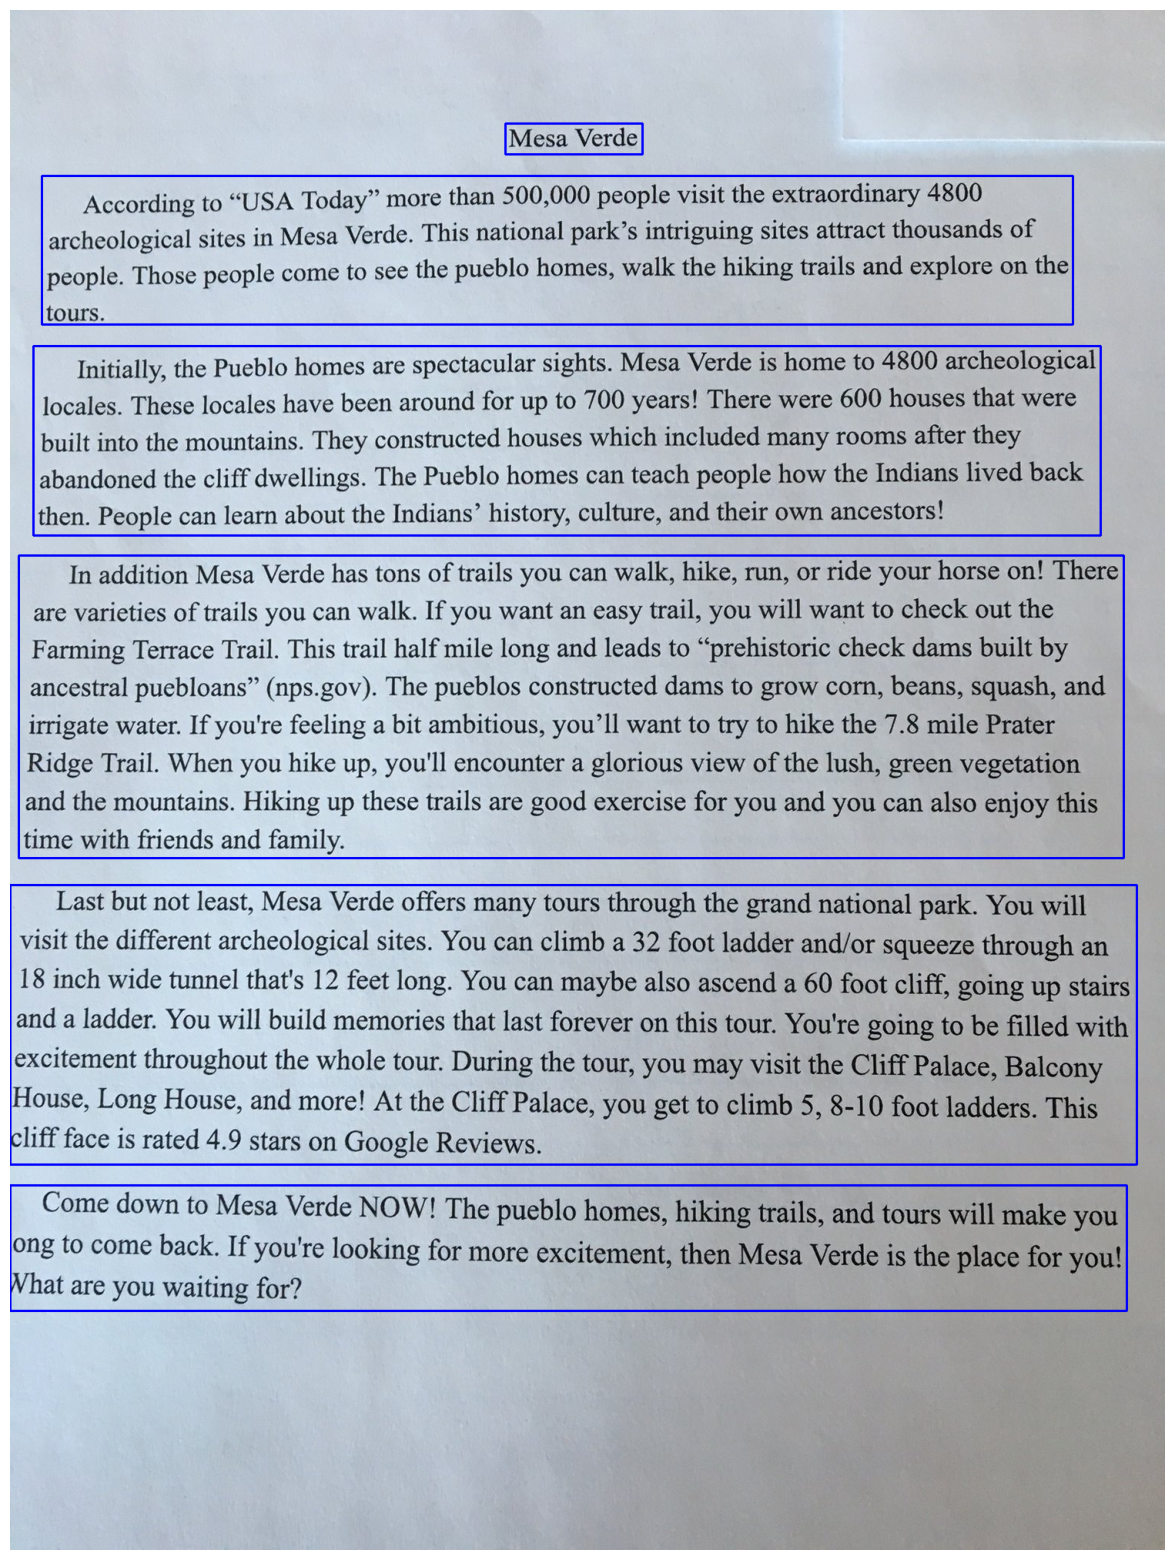

In [24]:
img = cv2.imread(IMAGE_PATH)
reader = easyocr.Reader(['en'])
result = reader.readtext(IMAGE_PATH)
paragraphs = create_para(resultp, x_ths=1, y_ths=0.3, mode='ltr')
img_with_boxes = draw_paragraph_boxes(img.copy(), paragraphs)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [143]:
def scan_paragraph(result, x_ths=1, y_ths=0.3, mode= 'ltr'):
    box_grp = []
    for box in result:
        all_x = [int(coord[0]) for coord in box [0]]
        all_y = [int(coord[1]) for coord in box [0]]
        min_x = min(all_x)
        max_x = max(all_x)
        min_y = min(all_y)
        max_y = max(all_y)
        height = max_x - min_y
        box_grp.append([box[1], min_x, max_x, min_y, max_y, height, 0.5*(min_y+max_y),0])
        cluster_grp=1
        while len([box for box in box_grp if box[7]==0])>0:
            box_grp0 = [box for box in box_grp if box[7] == 0]
            if len([box for box in box_grp if box[7]==cluster_grp]) == 0:
                box_grp0[0][7] = cluster_grp
            else:
                cluster_box_grp = [box for box in box_grp if box[7] == cluster_grp]
                mean_height = np.mean([box[5] for box in cluster_box_grp])
                min_px = min([box[1] for box in cluster_box_grp]) - x_ths*mean_height
                max_px = max([box[2] for box in cluster_box_grp]) + x_ths*mean_height
                min_py = min([box[3] for box in cluster_box_grp]) - y_ths*mean_height
                max_py = max([box[4] for box in cluster_box_grp]) + y_ths*mean_height
                add_box = False
                for box in box_grp0:
                    same_horizontal_level = (min_px<=box[1]<=max_px) or (min_px<=box[2]<=max_px)
                    same_vertical_level = (min_py<=box[3]<=max_py) or (min_py<=box[4]<=max_py)
                    if same_horizontal_level and same_vertical_level:
                        box[7] = cluster_grp
                        add_box = True
                        break
                if add_box==False:
                    cluster_grp += 1
    result = []
    for i in set(box[7] for box in box_grp):
        cluster_box_group = [box for box in box_grp if box[7]==i]
        mean_height = np.mean([box[5] for box in cluster_box_group])
        min_px = min([box[1] for box in cluster_box_grp])
        max_px = max([box[2] for box in cluster_box_grp])
        min_py = min([box[3] for box in cluster_box_grp])
        max_py = max([box[4] for box in cluster_box_grp])

        content = ''
        while len(cluster_box_grp) > 0:
            highest = min([box[6] for box in cluster_box_grp])
            candidates = [box for box in cluster_box_grp if box[6]<highest+0.4*mean_height]
            if mode == 'ltr':
                most_left = min([box[1] for box in candidates])
                for box in candidates:
                    if box[1] == most_left: best_box = box
            elif mode == 'rtl':
                most_right = max([box[2] for box in candidates])
                for box in candidates:
                    if box[2] == most_right: best_box = box
            content += ' '+best_box[0]
            cluster_box_grp.remove(best_box)

        result.append([ [[min_px,min_py],[max_px,min_py],[max_px,max_py],[min_px,max_py]], content[1:]])

    return result